In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az

In [3]:
df1 = pd.read_csv('data_01.csv')
df2 = pd.read_csv('data_02.csv')
df3 = pd.read_csv('data_03.csv')
df4 = pd.read_csv('data_04.csv')
df5 = pd.read_csv('data_05.csv')
df6 = pd.read_csv('data_06.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


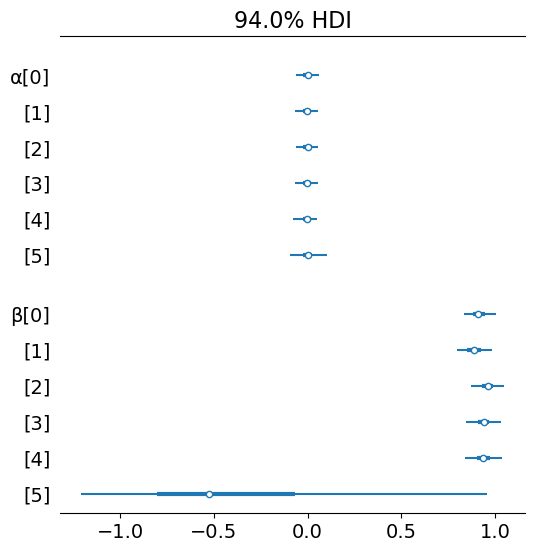

In [4]:
# Предполагается, что у нас имеются следующие данные
datasets = [df1, df2, df3, df4, df5, df6]

# Мы используем стандартизированные значения x и y для упрощения обработки
idd = []
for i, d in enumerate(datasets):
    datasets[i]['x'] = (d['x'] - d['x'].mean()) / d['x'].std()
    datasets[i]['y'] = (d['y'] - d['y'].mean()) / d['y'].std()
    idd.extend([i] * len(d))

x_m = np.concatenate([d['x'] for d in datasets])
y_m = np.concatenate([d['y'] for d in datasets])
M = len(datasets)

with pm.Model() as hierarchical_model:
    # априорные гипер-распределения
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    # априорные распеределения
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    # апосториорное распределение
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idd] + β[idd] * x_m,
    sigma=ε, nu=ν, observed=y_m)

    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    # трассировка
    trace_hm = pm.sample(3000, tune=1000, target_accept=.8)

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

In [9]:
pm.summary(trace_hm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_μ_tmp,-0.002,0.030,-0.057,0.050,0.002,0.001,287.0,599.0,1.01
β_μ,0.649,0.304,0.078,1.158,0.021,0.016,179.0,3277.0,1.02
α_tmp[0],-0.001,0.032,-0.061,0.061,0.002,0.001,344.0,691.0,1.00
α_tmp[1],-0.003,0.033,-0.067,0.054,0.002,0.001,256.0,2254.0,1.01
α_tmp[2],-0.002,0.032,-0.061,0.056,0.003,0.002,158.0,1293.0,1.02
α_tmp[3],-0.003,0.032,-0.067,0.056,0.002,0.001,307.0,278.0,1.01
α_tmp[4],-0.003,0.033,-0.077,0.049,0.003,0.002,143.0,80.0,1.02
α_tmp[5],-0.001,0.053,-0.096,0.103,0.002,0.001,474.0,741.0,1.01
β[0],0.912,0.047,0.832,1.008,0.002,0.001,815.0,3452.0,1.00
β[1],0.887,0.052,0.796,0.984,0.004,0.003,193.0,3591.0,1.02


array([[<Axes: title={'center': 'α_μ_tmp'}>,
        <Axes: title={'center': 'α_μ_tmp'}>],
       [<Axes: title={'center': 'β_μ'}>, <Axes: title={'center': 'β_μ'}>],
       [<Axes: title={'center': 'α_tmp'}>,
        <Axes: title={'center': 'α_tmp'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'α_σ_tmp'}>,
        <Axes: title={'center': 'α_σ_tmp'}>],
       [<Axes: title={'center': 'β_σ'}>, <Axes: title={'center': 'β_σ'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'α_μ'}>, <Axes: title={'center': 'α_μ'}>],
       [<Axes: title={'center': 'α_sd'}>,
        <Axes: title={'center': 'α_sd'}>]], dtype=object)

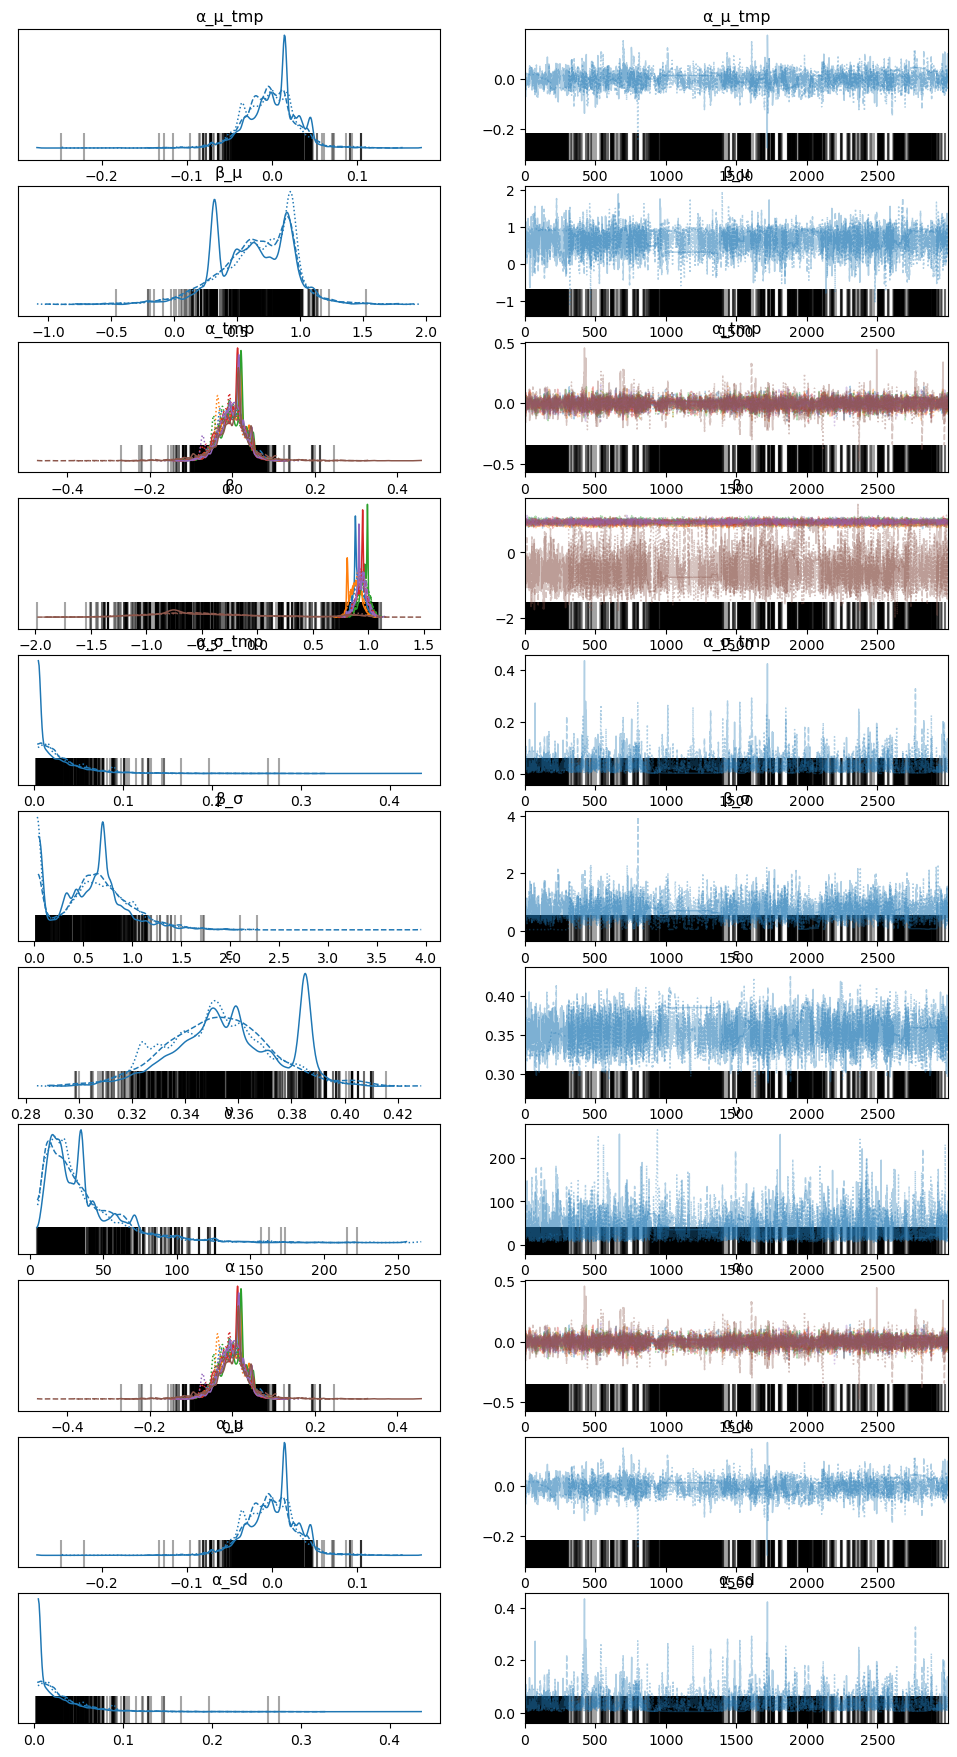

In [6]:
az.plot_trace(trace_hm)

In [7]:
from matplotlib import pyplot as plt

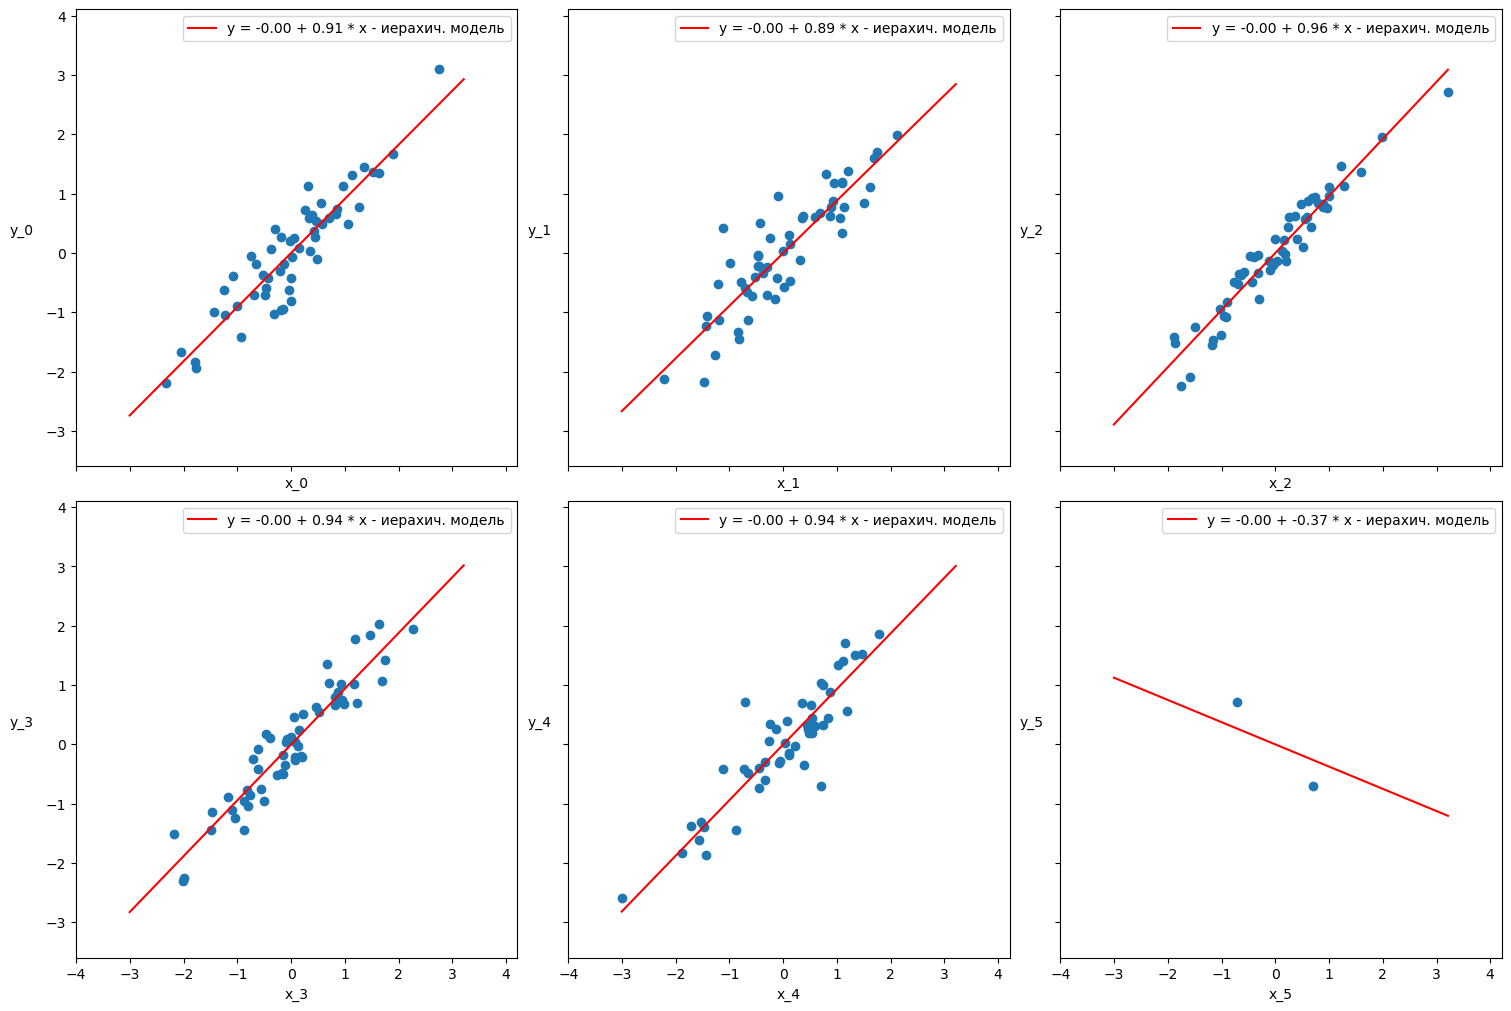

In [8]:
_, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True,
                     constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})


ax = np.ravel(ax)
j = 0
k = 55
x_range = np.linspace(x_m.min(), x_m.max(), 10)


for i in range(M):
    N = len(datasets[i])
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hmm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hmm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x'+' - иерахич. модель')


    ax[i].legend()
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N